Train
45 prediction boxes made for 5 actual boxes in set01_V003_I00759_Train for Train with note best (INDEX 0)


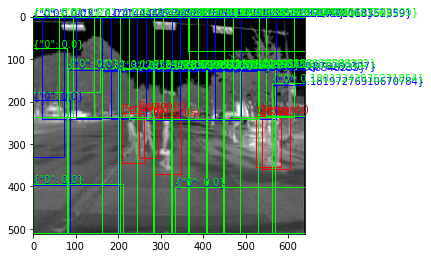

37.77777777777778 false positives (IOU = 0)
62.22222222222222 bad positives (0 < IOU < 0.5)
0.0 good positives (IOU >= 0.5)
Mean IOU: 0.04821576025975315
Figure set01_V003_I00759_Train_best.png saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2021_01_01-04_08_19_PM_NOTEBOOK.
Test
42 prediction boxes made for 3 actual boxes in set01_V003_I00630_Test for Test with note best (INDEX 0)


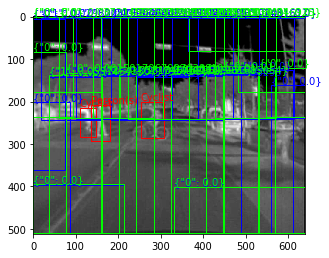

61.904761904761905 false positives (IOU = 0)
38.095238095238095 bad positives (0 < IOU < 0.5)
0.0 good positives (IOU >= 0.5)
Mean IOU: 0.020870748568731303
Figure set01_V003_I00630_Test_best.png saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2021_01_01-04_08_19_PM_NOTEBOOK.
Train Mean IOU: 0.016200117027120174
Test Mean IOU: 0.04821576025975315


In [1]:
# Imports
!pip install torchvision
import pandas as pd
import os
import numpy as np
from numpy.distutils.misc_util import is_sequence
from bs4 import BeautifulSoup  # this is to extract info from the xml, if we use it in the end
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import json
import pickle

import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import f1_score, precision_score, recall_score
import statistics

import os
from datetime import datetime
from pathlib import Path

Train
45 prediction boxes made for 5 actual boxes in set01_V003_I00759_Train for Train with note best (INDEX 0)


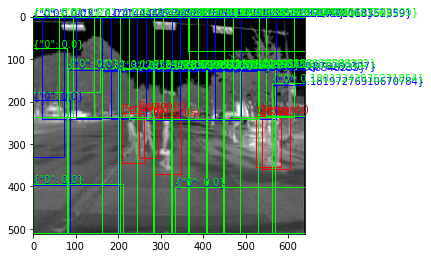

37.77777777777778 false positives (IOU = 0)
62.22222222222222 bad positives (0 < IOU < 0.5)
0.0 good positives (IOU >= 0.5)
Mean IOU: 0.04821576025975315
Figure set01_V003_I00759_Train_best.png saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2021_01_01-04_08_19_PM_NOTEBOOK.
Test
42 prediction boxes made for 3 actual boxes in set01_V003_I00630_Test for Test with note best (INDEX 0)


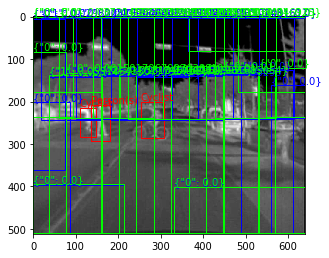

61.904761904761905 false positives (IOU = 0)
38.095238095238095 bad positives (0 < IOU < 0.5)
0.0 good positives (IOU >= 0.5)
Mean IOU: 0.020870748568731303
Figure set01_V003_I00630_Test_best.png saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2021_01_01-04_08_19_PM_NOTEBOOK.
Train Mean IOU: 0.016200117027120174
Test Mean IOU: 0.04821576025975315


In [2]:
local_mode = True
if local_mode:
    batch_size = 25
    num_epochs = 2
    epoch_partial_num = 1
    selfcsv_df = pd.read_csv("frame_MasterList.csv").head(75)
    dir_path = os.getcwd()
else:
    batch_size = 128
    num_epochs = 100
    epoch_partial_num = 100
    selfcsv_df = pd.read_csv("frame_MasterList.csv")
    dir_path = "/scratch/na3au/modelRuns"

try:
    current_time = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
    directory = dir_path + "/" + current_time + "_NOTEBOOK"
    if not os.path.exists(directory):
        os.makedirs(directory)
    print(f'Creation of directory at {directory} successful')
except:
    print(f'Creation of directory at {directory} failed')
file_output_path = directory + "/"

# Get label and encode
def get_box(obj):
    xmin = float(obj.find('xmin').text)
    xmax = float(obj.find('xmax').text)
    ymin = float(obj.find('ymin').text)
    ymax = float(obj.find('ymax').text)
    return [xmin, ymin, xmax, ymax]

def get_label(obj):
    if obj.find('name').text == 'person' or obj.find('name').text == 'people':
        return 1
    if obj.find('name').text == 'cyclist':
        return 2
    else:
        return 0

# Generate the target location in the image
def generate_target(image_id, file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')  # probably will have to change this
        objects = soup.find_all('object')

        num_objs = len(objects)

        boxes = []
        labels = []

        for i in objects:
            boxes.append(get_box(i))
            labels.append(get_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        img_id = torch.tensor([image_id])

        # Creating the target for the box
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = img_id

        return target

def OHE(label):
    if label == "People" or label == "Person":
        return 1
    elif label == "Cyclist":
        return 2
    else:
        return 0


def Recode(label):
    if label == 1:
        return "Person(s)"
    elif label == 2:
        return "Cyclist"
    else:
        return "N/A"


class FullImages(object):
    def __init__(self, transforms=None):
        self.csv = selfcsv_df
        self.csv_len = self.csv.shape[1]
        self.imgs = self.csv.image_path.tolist()
        self.imgs_len = len(self.imgs)
        self.transforms = transforms

    def __len__(self):
        return self.imgs_len
        # return self.csv_len

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = self.csv.loc[idx, 'image_path']
        annotation = self.csv.loc[idx, 'annotation_path']

        img = Image.open(img).convert("L")
        target = generate_target(idx, annotation)

        # label = self.labels[idx]
        # label = OHE(label)
        # label = torch.as_tensor(label, dtype=torch.int64)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

# Normalize
data_transform = transforms.Compose([  # transforms.Resize((80,50)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]
                         )])

# Collate images
def collate_fn(batch):
    return tuple(zip(*batch))  # will need adjusting when pathing is adjusted

dataset = FullImages(data_transform)
data_size = len(dataset)
print(f'Length of Dataset: {data_size}')

indices = list(range(data_size))
test_split = 0.2
split = int(np.floor(test_split * data_size))
# print(f'Length of Split Dataset: {split}')

train_indices, test_indices = indices[split:], indices[:split]
len_train_ind, len_test_ind = len(train_indices), len(test_indices)
print(f'Length of Train: {len_train_ind}; Length of Test: {len_test_ind}')

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=train_sampler,
    collate_fn=collate_fn
)

len_dataloader = len(data_loader)
print(f'Length of train: {len_dataloader}')

data_loader_test = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler,
                                               collate_fn=collate_fn)
len_testdataloader = len(data_loader_test)
print(f'Length of test: {len_testdataloader}')

# Check if GPU
cuda = torch.cuda.is_available()
if cuda:
    device = torch.device("cuda")
    print(f'CUDA device')
else:
    device = torch.device("cpu")
    print(f'CPU device')

# Instance segmentation is crucial in using the full images
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(
        in_features, num_classes)
    return model

# cnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = False)
model = get_model_instance_segmentation(3)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params)  # , lr = 0.005, weight_decay = 0.0005)

tot_ats = 0
epochs = 0
epoch_ats = []
epoch_losses = []
df = pd.DataFrame({'Mean_Epoch_Loss': epoch_losses})
for epoch in range(num_epochs):
    epochs += 1
    print(f'Epoch: {epochs}')
    model.train()
    epoch_loss = 0
    i = 0
    for train_imgs, train_annotations in data_loader:
        imgs = list(img.to(device) for img in train_imgs)
        ats = [{k: v.to(device) for k, v in t.items()} for t in train_annotations]
        loss_dict = model([imgs[0]], [ats[0]])
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        i += 1
        tot_ats += 1

        epoch_loss += losses
        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')

    mean_epoch_loss = epoch_loss / i
    epoch_losses.append(mean_epoch_loss)
    epoch_ats.append(i)

try:
    # Save training metrics
    full_name = "full_model_losses_" + str(epochs) + ".csv"
    df.to_csv(file_output_path + full_name, index=False)
    print(f'Full model losses for {epochs} epochs saved to {directory}.')
except:
    pass

try:
    # Save model
    torch.save(model.state_dict(), file_output_path + 'full_model.pt')
    print(f'Full model trained on {epochs} epochs saved to {directory}.')
except:
    pass

print(f'Total Trained: {tot_ats}')
epoch_ats


master_csv = pd.read_csv("frame_MasterList.csv")
model.eval()

for train_imgs, train_annotations in data_loader:
    imgs_train = list(img_train.to(device) for img_train in train_imgs)
    annotations_train = [{k: v.to(device) for k, v in t.items()} for t in train_annotations]

for test_imgs, test_annotations in data_loader_test:
    imgs_test = list(img_test.to(device) for img_test in test_imgs)
    annotations_test = [{k: v.to(device) for k, v in t.items()} for t in test_annotations]

train_imgs = [t.to(device) for t in train_imgs]
test_imgs = [t.to(device) for t in test_imgs]

train_annotations = [{'boxes': d['boxes'].to(device), 'labels': d['labels'].to(device),
                      'image_id': d['image_id'].to(device)} for d in train_annotations]
test_annotations = [{'boxes': d['boxes'].to(device), 'labels': d['labels'].to(device),
                     'image_id': d['image_id'].to(device)} for d in test_annotations]

test_annotations_list = []
for dictionary in test_annotations:
    annotation = dictionary['image_id']
    test_annotations_list.append(annotation)

train_annotations_list = []
for dictionary in train_annotations:
    annotation = dictionary['image_id']
    train_annotations_list.append(annotation)

print(f'{len(test_annotations_list)} unique image ids in test annotations')
print(f'{len(train_annotations_list)} unique image ids in train annotations')

print("Train Predictions")
preds_train = model(train_imgs)
print(len(preds_train))
print(preds_train[0])

print("Test Predictions")
preds_test = model(test_imgs)
print(len(preds_test))
print(preds_test[0])

if preds_train == preds_test:
    print(preds_train == preds_test)
else:
    pass



Train
45 prediction boxes made for 5 actual boxes in set01_V003_I00759_Train for Train with note best (INDEX 0)


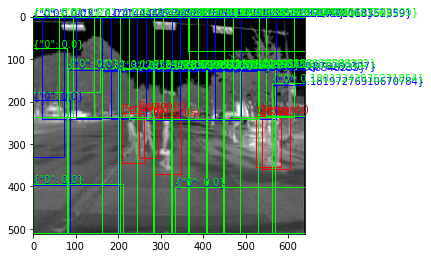

37.77777777777778 false positives (IOU = 0)
62.22222222222222 bad positives (0 < IOU < 0.5)
0.0 good positives (IOU >= 0.5)
Mean IOU: 0.04821576025975315
Figure set01_V003_I00759_Train_best.png saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2021_01_01-04_08_19_PM_NOTEBOOK.
Test
42 prediction boxes made for 3 actual boxes in set01_V003_I00630_Test for Test with note best (INDEX 0)


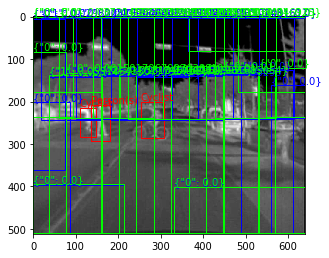

61.904761904761905 false positives (IOU = 0)
38.095238095238095 bad positives (0 < IOU < 0.5)
0.0 good positives (IOU >= 0.5)
Mean IOU: 0.020870748568731303
Figure set01_V003_I00630_Test_best.png saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2021_01_01-04_08_19_PM_NOTEBOOK.
Train Mean IOU: 0.016200117027120174
Test Mean IOU: 0.04821576025975315


In [4]:
def get_iou(num, input, test=False):
    if test:
        identifier = "Test"
        annotation = test_annotations[num]
        prediction = preds_test[num]
    else:
        identifier = "Train"
        annotation = train_annotations[num]
        prediction = preds_train[num]

    annotation_boxes = annotation["boxes"].tolist()

    ix = 0
    for box in annotation["boxes"]:
        img_id = annotation["image_id"].item()
        file_name = master_csv.loc[img_id, :].image_path
        set = file_name.split("/")[7]
        video = file_name.split("/")[8]
        file_name = file_name.split("/")[10]
        file_name = file_name[:-4]
        output_name = set + "_" + video + "_" + file_name
        ix += 1

    ix = 0
    voc_iou = []
    #print(f'{len(prediction["boxes"])} prediction boxes made for {len(annotation["boxes"])} actual boxes in {str(output_name)} for {identifier} with note {input}')
    for box in prediction["boxes"]:
        xmin, ymin, xmax, ymax = box.tolist()
        iou_list = []
        for bound in annotation_boxes:
            a_xmin, a_ymin, a_xmax, a_ymax = bound
            xA = max(xmin, a_xmin)
            yA = max(ymin, a_ymin)
            xB = min(xmax, a_xmax)
            yB = min(ymax, a_ymax)
            interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
            p_area = (xmax - xmin + 1) * (ymax - ymin + 1)
            a_area = (a_xmax - a_xmin + 1) * (a_ymax - a_ymin + 1)
            iou = interArea / float(p_area + a_area - interArea)
            iou_list.append(iou)
        max_val = max(iou_list)
        voc_iou.append(max_val)
        ix += 1

    if len(voc_iou) == 0:
        mean_iou = 0
        print(f'No predictions made so Mean IOU: {mean_iou}')
    else:
        mean_iou = sum(voc_iou) / len(voc_iou)

    return [mean_iou, voc_iou]

def plot_images(num, input):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    img_tensor = imgs[num]
    annotation = train_annotations[num]
    prediction = preds_train[num]

    img = img_tensor.cpu().data
    img = img[0, :, :]

    ax[0].imshow(img, cmap='gray')
    ax[1].imshow(img, cmap='gray')

    ix = 0
    for box in annotation["boxes"]:
        # print(annotations[ix])
        xmin, ymin, xmax, ymax = box.tolist()
        value = annotation["labels"][ix]
        img_id = annotation["image_id"].item()
        file_name = master_csv.loc[img_id, :].image_path
        set = file_name.split("/")[7]
        video = file_name.split("/")[8]
        file_name = file_name.split("/")[10]
        file_name = file_name[:-4]
        output_name = set + "_" + video + "_" + file_name
        text = Recode(value)
        colors = ["r", "#00FF00", "#0000FF"]
        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1,
                                 edgecolor=colors[value], facecolor='none')
        target_x = xmin
        target_y = ymin - 5
        ax[0].text(target_x, target_y, text, color=colors[value])
        ax[0].add_patch(rect)
        ix += 1

    ix = 0
    print(str(len(prediction["boxes"])) + " prediction boxes made for " + str(
        len(annotation["boxes"])) + " actual boxes in " + str(output_name))
    for box in prediction["boxes"]:
        xmin, ymin, xmax, ymax = box.tolist()
        value = prediction["labels"][ix]
        text = Recode(value)
        colors = ["r", "#00FF00", "#0000FF"]
        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1,
                                 edgecolor=colors[value], facecolor='none')
        target_x = xmin
        target_y = ymin - 5
        ax[1].text(target_x, target_y, text, color=colors[value])
        ax[1].add_patch(rect)
        ix += 1

    # figname = file_name+"_"+input+".png"
    # fig.savefig(figname)
    plt.show()

def plot_iou(num, input, test=False):
    fig, ax = plt.subplots(1)
    if test:
        identifier = "Test"
        print(identifier)
        img_tensor = test_imgs[num]
        annotation = test_annotations[num]
        prediction = preds_test[num]
    else:
        identifier = "Train"
        print(identifier)
        img_tensor = train_imgs[num]
        annotation = train_annotations[num]
        prediction = preds_train[num]

    img = img_tensor.cpu().data
    img = img[0, :, :]
    annotation_boxes = annotation["boxes"].tolist()

    ax.imshow(img, cmap='gray')

    ix = 0
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box.tolist()
        value = annotation["labels"][ix]
        img_id = annotation["image_id"].item()
        file_name = master_csv.loc[img_id, :].image_path
        set = file_name.split("/")[7]
        video = file_name.split("/")[8]
        file_name = file_name.split("/")[10]
        file_name = file_name[:-4]
        output_name = set + "_" + video + "_" + file_name + "_" + identifier
        text = Recode(value)
        colors = ["r", "r", "r"]
        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1,
                                 edgecolor=colors[value], facecolor='none')
        target_x = xmin
        target_y = ymin - 5
        ax.text(target_x, target_y, text, color=colors[value])
        ax.add_patch(rect)
        ix += 1

    ix = 0
    voc_iou = []
    print(
        f'{len(prediction["boxes"])} prediction boxes made for {len(annotation["boxes"])} actual boxes in {str(output_name)} for {identifier} with note {input} (INDEX {num})')
    for box in prediction["boxes"]:
        xmin, ymin, xmax, ymax = box.tolist()

        iou_list = []
        for bound in annotation_boxes:
            a_xmin, a_ymin, a_xmax, a_ymax = bound
            xA = max(xmin, a_xmin)
            yA = max(ymin, a_ymin)
            xB = min(xmax, a_xmax)
            yB = min(ymax, a_ymax)
            interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
            p_area = (xmax - xmin + 1) * (ymax - ymin + 1)
            a_area = (a_xmax - a_xmin + 1) * (a_ymax - a_ymin + 1)
            iou = interArea / float(p_area + a_area - interArea)
            iou_list.append(iou)
        max_val = max(iou_list)
        voc_iou.append(max_val)

        max_ix = iou_list.index(max_val)
        map_dict = {max_ix: max_val}

        # iou_string = ', '.join((str(float) for float in iou_list))
        value = prediction["labels"][ix]
        text = json.dumps(map_dict)
        colors = ["r", "#00FF00", "#0000FF"]
        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1,
                                 edgecolor=colors[value], facecolor='none')
        target_x = xmin
        target_y = ymin - 5
        ax.text(target_x, target_y, text, color=colors[value])
        ax.add_patch(rect)
        ix += 1

    plt.show()

    if len(voc_iou) == 0:
        mean_iou = 0
        print(f'No predictions made so Mean IOU: {mean_iou}')
    else:
        mean_iou = sum(voc_iou) / len(voc_iou)
        fp = voc_iou.count(0) / len(voc_iou) * 100
        bp = sum((i > 0 and i < 0.5) for i in voc_iou) / len(voc_iou) * 100
        gp = sum((i >= 0.5) for i in voc_iou) / len(voc_iou) * 100
        print(f'{fp} false positives (IOU = 0)')
        print(f'{bp} bad positives (0 < IOU < 0.5)')
        print(f'{gp} good positives (IOU >= 0.5)')
        print(f'Mean IOU: {mean_iou}')

    figname = output_name + "_" + input + ".png"
    fig.savefig(file_output_path + figname)
    print(f'Figure {figname} saved to {directory}.')


print(f'Train is {len(preds_train)} and test is {len(preds_test)}')

plot_images(0, "first")

plot_iou(0, "first", False)
plot_iou(len(preds_train) - 1, "last", False)

get_iou(len(preds_train) - 1, "last", False)[0]

plot_iou(0, "first", True)
plot_iou(len(preds_test) - 1, "last", True)

get_iou(len(preds_test) - 1, "last", True)[0]

iou_df_train = pd.DataFrame(columns=["Train_Mean_IOU", "IOU_List"])
iou_df_train_name = "full_iou_TRAIN_" + str(epochs) + ".csv"
for train_pred in range(0, len(preds_train)):
    iou_function = get_iou(train_pred, "first", False)
    len_df = len(iou_df_train)
    iou_df_train.loc[len_df, :] = iou_function
    try:
        if train_pred % 50 == 0:
            iou_df_train.to_csv(file_output_path + iou_df_train_name, index=False)
            print(f'Partial train IOUs for {len(iou_df_train)} images saved to {directory}.')
    except:
        pass

iou_df_train.to_csv(file_output_path + iou_df_train_name, index=False)
print(f'Full train IOUs for {len(iou_df_train)} images saved to {directory}.')

print(iou_df_train.sort_values(by='Train_Mean_IOU', ascending=False).head(5))

iou_df_test = pd.DataFrame(columns=["Test_Mean_IOU", "IOU_List"])
iou_df_test_name = "full_iou_TEST_" + str(epochs) + ".csv"
for test_pred in range(0, len_testdataloader):
    iou_function = get_iou(test_pred, "test", False)
    len_df = len(iou_df_test)
    iou_df_test.loc[len_df, :] = iou_function
    try:
        if test_pred % 50 == 0:
            iou_df_test.to_csv(file_output_path + iou_df_test_name, index=False)
            print(f'Partial train IOUs for {len(iou_df_test)} images saved to {directory}.')
    except:
        pass

iou_df_test.to_csv(file_output_path + iou_df_test_name, index=False)
print(f'Full train IOUs for {len(iou_df_test)} images saved to {directory}.')

print(iou_df_test.sort_values(by='Test_Mean_IOU', ascending=False).head(5))


Train
45 prediction boxes made for 5 actual boxes in set01_V003_I00759_Train for Train with note best (INDEX 0)


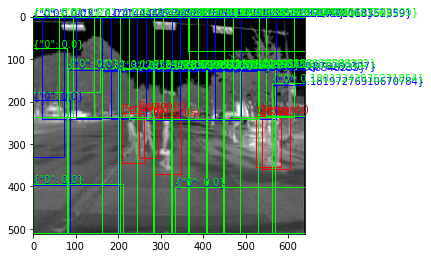

37.77777777777778 false positives (IOU = 0)
62.22222222222222 bad positives (0 < IOU < 0.5)
0.0 good positives (IOU >= 0.5)
Mean IOU: 0.04821576025975315
Figure set01_V003_I00759_Train_best.png saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2021_01_01-04_08_19_PM_NOTEBOOK.
Test
42 prediction boxes made for 3 actual boxes in set01_V003_I00630_Test for Test with note best (INDEX 0)


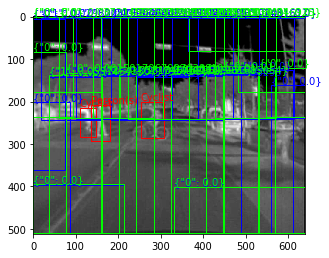

61.904761904761905 false positives (IOU = 0)
38.095238095238095 bad positives (0 < IOU < 0.5)
0.0 good positives (IOU >= 0.5)
Mean IOU: 0.020870748568731303
Figure set01_V003_I00630_Test_best.png saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2021_01_01-04_08_19_PM_NOTEBOOK.
Train Mean IOU: 0.016200117027120174
Test Mean IOU: 0.04821576025975315


In [5]:

max_train_ix = iou_df_train[iou_df_train['Train_Mean_IOU'] == iou_df_train['Train_Mean_IOU'].max()].index.tolist()[0]
max_test_ix = iou_df_test[iou_df_test['Test_Mean_IOU'] == iou_df_test['Test_Mean_IOU'].max()].index.tolist()[0]

plot_iou(max_train_ix, "best", False)

plot_iou(max_test_ix, "best", True)

print(f'Train Mean IOU: {iou_df_train["Train_Mean_IOU"].mean()}')
print(f'Test Mean IOU: {iou_df_test["Test_Mean_IOU"].mean()}')
